In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv


In [2]:
customers = pd.read_csv("../input/brazilian-ecommerce/olist_customers_dataset.csv")
geolocation = pd.read_csv("../input/brazilian-ecommerce/olist_geolocation_dataset.csv")
order_items = pd.read_csv("../input/brazilian-ecommerce/olist_order_items_dataset.csv")
order_payments = pd.read_csv("../input/brazilian-ecommerce/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("../input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
orders = pd.read_csv("../input/brazilian-ecommerce/olist_orders_dataset.csv")
products = pd.read_csv("../input/brazilian-ecommerce/olist_products_dataset.csv")
sellers = pd.read_csv("../input/brazilian-ecommerce/olist_sellers_dataset.csv")
category_name_translation = pd.read_csv("../input/brazilian-ecommerce/product_category_name_translation.csv")

Let's merge theses dataframes

In [3]:
# creating master dataframe 
print(order_payments.shape)
df1 = order_payments.merge(order_items, on='order_id')
print(df1.shape)
df2 = df1.merge(products, on='product_id')
print(df2.shape)
df3 = df2.merge(sellers, on='seller_id')
print(df3.shape)
df4 = df3.merge(order_reviews, on='order_id')
print(df4.shape)
df5 = df4.merge(orders, on='order_id')
print(df5.shape)
df6 = df5.merge(category_name_translation, on='product_category_name')
print(df6.shape)
df = df6.merge(customers, on='customer_id')
print(df.shape)

(103886, 5)
(117601, 11)
(117601, 19)
(117601, 22)
(118315, 28)
(118315, 35)
(116581, 36)
(116581, 40)


In [4]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [5]:
# cleaning up name columns, and engineering new/essential columns
df['customer_city'] = df['customer_city'].str.title()
df['seller_city'] = df['seller_city'].str.title()
df['product_category_name_english'] = df['product_category_name_english'].str.title()
df['payment_type'] = df['payment_type'].str.replace('_', ' ').str.title()
df['product_category_name_english'] = df['product_category_name_english'].str.replace('_', ' ')
df['review_response_time'] = (df['review_answer_timestamp'] - df['review_creation_date']).dt.days
df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['product_size_cm'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
df['order_purchase_year'] = df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df.order_purchase_timestamp.apply(lambda x: x.month).map({0:'Jan',1:'Feb',2:'Mar',3:'Apr',4:'May',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'})

In [6]:
# dropping non-needed columns
df = df.drop(["product_name_lenght", "product_description_lenght", "product_photos_qty", "product_length_cm", "product_height_cm", "product_width_cm", "product_length_cm", "review_id","review_comment_title", "review_comment_message", "product_category_name", "order_purchase_month","order_purchase_year","order_purchase_dayofweek", "order_purchase_hour"], axis=1)

In [7]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
df_missing_values = pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage'])
display(df_missing_values[df_missing_values['Values']!= 0].transpose())

,order_purchase_mon,order_delivered_customer_date,delivery_against_estimated,order_delivered_carrier_date,order_approved_at,product_size_cm,product_weight_g
Values,6443.00000,2515.000000,2515.000000,1213.000000,14.000000,1.000000,1.000000
Percentage,5.52663,2.157298,2.157298,1.040478,0.012009,0.000858,0.000858


In [8]:
# dropping missing values
df.dropna(inplace=True)

In [9]:
# displaying dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107722 entries, 0 to 116579
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       107722 non-null  object        
 1   payment_sequential             107722 non-null  int64         
 2   payment_type                   107722 non-null  object        
 3   payment_installments           107722 non-null  int64         
 4   payment_value                  107722 non-null  float64       
 5   order_item_id                  107722 non-null  int64         
 6   product_id                     107722 non-null  object        
 7   seller_id                      107722 non-null  object        
 8   shipping_limit_date            107722 non-null  datetime64[ns]
 9   price                          107722 non-null  float64       
 10  freight_value                  107722 non-null  float64       
 11  

In [10]:
with pd.option_context('display.max_columns', df.shape[1]):
    display(df)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,seller_zip_code_prefix,seller_city,seller_state,review_score,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_response_time,delivery_against_estimated,product_size_cm,order_purchase_day,order_purchase_mon
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,800.0,13321,Salto,SP,1,2018-05-10,2018-05-15 23:38:00,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,Home Construction,708ab75d2a007f0564aedd11139c7708,39801,Teofilo Otoni,MG,5,12.0,7803.0,Wed,May
1,d86305c284cecff56c7ee9d3fbd4f8d6,1,Credit Card,4,93.72,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-04-19 23:10:02,79.80,13.92,800.0,13321,Salto,SP,4,2018-04-21,2018-04-21 10:31:10,0e37385834260d6111727103a93e790a,delivered,2018-04-15 22:53:59,2018-04-15 23:10:32,2018-04-16 23:54:55,2018-04-20 00:07:39,2018-05-09,Home Construction,550a1a0e8ad53e4147e6c761b5699c2b,14781,Barretos,SP,0,18.0,7803.0,Sun,May
2,5308fdab519f7478ef64894128fbbee4,1,Credit Card,1,36.07,1,1b93af229a5768eaaed2064722b1c1dc,213b25e6f54661939f11710a6fddb871,2018-06-11 12:11:27,129.95,18.79,9950.0,13321,Salto,SP,5,2018-06-21,2018-06-24 20:43:00,3aec6e3846fd122ac430ac1a816107a8,delivered,2018-06-02 11:51:00,2018-06-02 12:11:27,2018-06-05 15:02:00,2018-06-20 23:09:42,2018-07-13,Home Construction,74fe4e106702770ef728399ce5da503a,74823,Goiania,GO,3,22.0,59488.0,Sat,Jul
3,5308fdab519f7478ef64894128fbbee4,2,Voucher,1,112.67,1,1b93af229a5768eaaed2064722b1c1dc,213b25e6f54661939f11710a6fddb871,2018-06-11 12:11:27,129.95,18.79,9950.0,13321,Salto,SP,5,2018-06-21,2018-06-24 20:43:00,3aec6e3846fd122ac430ac1a816107a8,delivered,2018-06-02 11:51:00,2018-06-02 12:11:27,2018-06-05 15:02:00,2018-06-20 23:09:42,2018-07-13,Home Construction,74fe4e106702770ef728399ce5da503a,74823,Goiania,GO,3,22.0,59488.0,Sat,Jul
4,bb54e9bf4bdb6c6391a7c6b517748b9f,1,Credit Card,2,124.92,1,71540d636652fc682032d3b3c0a180c1,213b25e6f54661939f11710a6fddb871,2018-06-04 11:50:16,113.85,11.07,1050.0,13321,Salto,SP,3,2018-06-27,2018-06-30 16:09:07,84e28130ed1fa8558f3fc843d9a906e7,delivered,2018-05-27 11:41:32,2018-05-27 11:50:16,2018-06-01 15:13:00,2018-06-26 18:04:00,2018-07-04,Home Construction,da9a13d9200966b860d4a17a98fcf59b,36120,Matias Barbosa,MG,3,7.0,6912.0,Sun,Jun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116575,9c9d2097d4c2b46f2963f34e32a57f35,1,Credit Card,2,79.61,1,6e7f4ae007302e93c5610894712289bb,7f35f9daf223da737b78738fbae4d977,2018-06-29 13:17:39,60.00,19.61,1250.0,13272,Valinhos,SP,4,2018-07-04,2018-07-05 11:25:44,44273202e14786abae757d5cd54ebba9,delivered,2018-06-25 13:07:22,2018-06-25 13:17:39,2018-06-26 10:38:00,2018-07-04 00:59:39,2018-07-25,Diapers And Hygiene,d95f9cf8ced1c4fc2f2f05434c3f211d,86300,Cornelio Procopio,PR,1,20.0,7040.0,Mon,Jul
116576,d4665434b01caa9dc3e3e78b3eb3593e,1,Credit Card,5,79.61,1,6e7f4ae007302e93c5610894712289bb,7f35f9daf223da737b78738fbae4d977,2018-06-22 05:31:36,60.00,19.61,1250.0,13272,Valinhos,SP,5,2018-06-22,2018-06-26 13:51:29,430629c51214778912efab67e023a8f1,delivered,2018-06-18 05:22:00,2018-06-18 06:09:34,2018-06-18 13:43:00,2018-06-21 22:48:57,2018-07-13,Diapers And Hygiene,3b9b60dd4a5ca201735e213fba2946f1,28994,Saquarema,RJ,4,21.0,7040.0,Mon,Jul
116577,eb4fc04dec501a9893d00e5090e59f7d,1,Boleto,1,37.39,1,a9e010c9e4e10e358d3baf52bb920893,e3dd723429d1b23614b7fa85e2c7a

In [11]:
# displaying summary staticstics of columns
with pd.option_context('display.max_columns', df.shape[1]):
    display(df.describe(include = 'all'))

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,seller_zip_code_prefix,seller_city,seller_state,review_score,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_response_time,delivery_against_estimated,product_size_cm,order_purchase_day,order_purchase_mon
count,107722,107722.000000,107722,107722.000000,107722.000000,107722.000000,107722,107722,107722,107722.000000,107722.000000,107722.000000,107722.000000,107722,107722,107722.000000,107722,107722,107722,107722,107722,107722,107722,107722,107722,107722,107722,107722.000000,107722,107722,107722.000000,107722.000000,107722.000000,107722,107722
unique,89725,NaN,4,NaN,NaN,NaN,30655,2901,85082,NaN,NaN,NaN,NaN,587,22,NaN,623,89421,89725,2,89242,82227,73767,88972,441,71,86935,NaN,4020,27,NaN,NaN,NaN,7,11
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,Credit Card,NaN,NaN,NaN,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,NaN,NaN,Sao Paulo,SP,NaN,2018-05-15 00:00:00,2017-08-17 22:17:55,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2018-03-12 00:00:00,Bed Bath Table,9a736b248f67d166d2fbb006bcb877c3,NaN,Sao Paulo,SP,NaN,NaN,NaN,Mon,Sep
freq,63,NaN,79519,NaN,NaN,NaN,497,2020,63,NaN,NaN,NaN,NaN,26693,76805,NaN,521,63,63,107715,63,63,63,63,594,11235,75,NaN,17038,45428,NaN,NaN,NaN,17574,12348
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-08 10:34:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-15 00:00:00,2016-10-16 03:20:17,NaN,NaN,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-31 00:00:00,2018-10-29 12:27:35,NaN,NaN,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.090167,NaN,2.948219,172.901502,1.199291,NaN,NaN,NaN,120.176300,20.068994,2111.367149,24565.997401,NaN,NaN,4.072037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35125.346976,NaN,NaN,2.584885,10.994597,15346.951486,NaN,NaN
std,NaN,0.674717,NaN,2.780872,269.819362,0.707823,NaN,NaN,NaN,183.368708,15.832142,3769.392616,27674.427504,NaN,NaN,1.354741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29898.253362,NaN,NaN,9.834978,10.194566,23481.507942,NaN,NaN
min,NaN,1.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.850000,0.000000,0.000000,1001.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.000000,NaN,NaN,0.000000,-189.000000,168.000000,NaN,NaN
25%,NaN,1.000000,NaN,1.000000,60.850000,1.000000,NaN,NaN,NaN,39.900000,13.080000,300.000000,6429.000000,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11250.000000,NaN,NaN,1.000000,6.000000,2856.000000,NaN,NaN


Let's look at the 25% top categories in term of Revenue

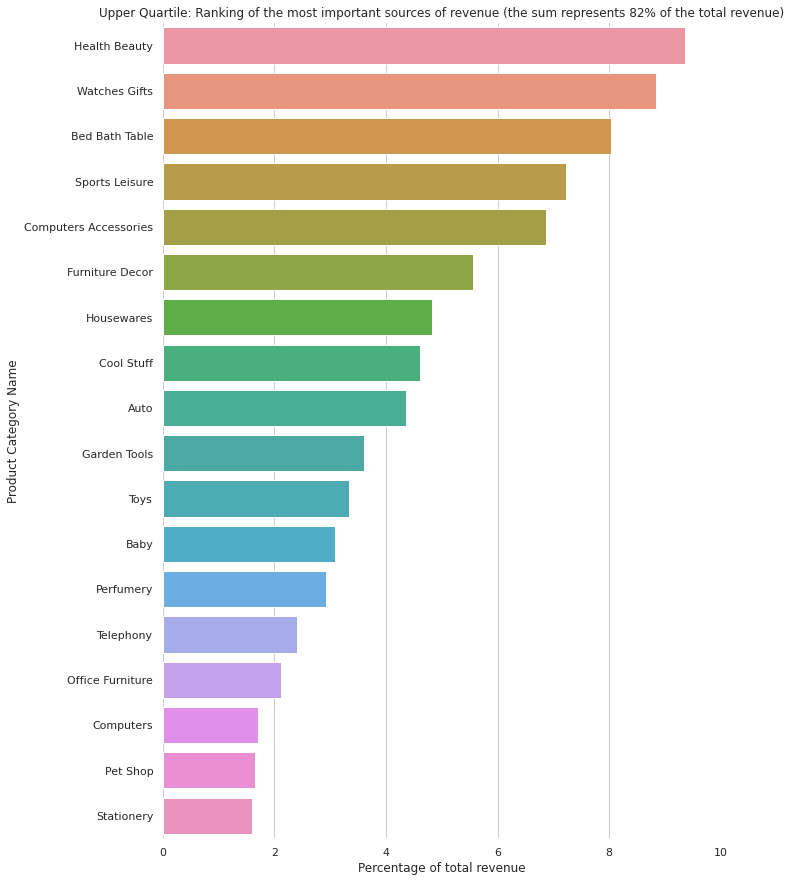

In [12]:
upper_quartile = (100*df[['product_category_name_english','price']][df['order_status'] == 'delivered'].groupby('product_category_name_english')['price'].sum().sort_values(ascending=False)/df['price'].sum())
upper_quartile = pd.DataFrame(upper_quartile)
upper_quartile = upper_quartile[upper_quartile['price'] > upper_quartile['price'].quantile(0.75)]
upper_quartile_revenue = str(int(round(upper_quartile['price'].sum())))

from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(y=upper_quartile.index,x=upper_quartile.price,data=upper_quartile)


# Add a legend and informative axis label


plt.title('Upper Quartile: Ranking of the most important sources of revenue (the sum represents '+upper_quartile_revenue+'% of the total revenue)')
#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, ceil(upper_quartile.max())), ylabel="Product Category Name",
       xlabel="Percentage of total revenue")
sns.despine(left=True, bottom=True)

They represent 82% of the total revenue!

In [13]:
delivery_score_1 = df[df['review_score']==1][['delivery_against_estimated']]
delivery_score_2 = df[df['review_score']==2][['delivery_against_estimated']]
delivery_score_3 = df[df['review_score']==3][['delivery_against_estimated']]
delivery_score_4 = df[df['review_score']==4][['delivery_against_estimated']]
delivery_score_5 = df[df['review_score']==5][['delivery_against_estimated']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c53dc54d0>]],
      dtype=object)

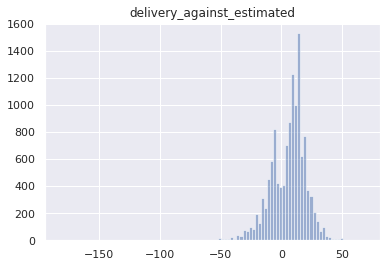

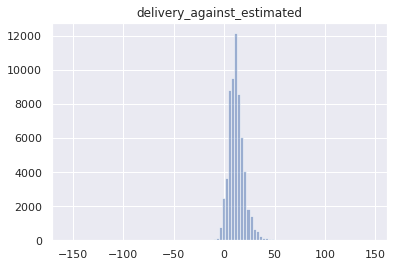

In [16]:
sns.set(font_scale=1)
delivery_score_1.hist(bins=100,alpha = 0.5)
delivery_score_5.hist(bins=100,alpha=0.5)